In [1]:
import pandas as pd
import micom
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import statsmodels.api as sm
import sklearn.metrics
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import wilcoxon
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Analyze qPCR Data

## Collect Metadata

In [2]:
# Collect metadata 
metadata = pd.read_table('../Hiseq_metagenomic_202_190916 metadata_conditions.txt')

# Drop header and control rows
metadata = metadata.drop(metadata.index[[0,83,84]])

# Create dictionary with subject IDs
subject_dict = metadata.set_index('Name')['subject_id'].to_dict()
treatment_dict = metadata.set_index('Name')['treatment_group'].to_dict()
metadata

,Name,subject_id,time_point,treatment_group
1,C0223873,SS_65,00_Baseline,wbf11
2,C0253061,SS_60,00_Baseline,wbf11
3,C0227725,SS_46,00_Baseline,wbf11
4,C0264833,SS_31,12_Week,placebo
5,C0252289,SS_67,00_Baseline,wbf11
...,...,...,...,...
78,C0228492,SS_118,12_Week,placebo
79,C1064093,SS_102,12_Week,wbf11
80,C0231040,SS_76,12_Week,placebo
81,C0263808,SS_71,12_Week,placebo


## Import qPCR Table

In [3]:
qPCR = pd.read_table('../qPCR/qPCR-reaction-table.tsv')

# Remove cycle threshold of -inf
qPCR_Ct = qPCR[qPCR['Ct']!= -np.inf].sort_values(by = 'Ct') 

# Remove reads that failed QC, filter
qPCR_filter = qPCR_Ct[(qPCR_Ct['PassQC'] == True)&(qPCR_Ct['PassFilter'] == True)]
# qPCR_filter = qPCR_Ct.copy()


# Remove less efficient primers for EHAL, CBEI
qPCR_filter = qPCR_filter.loc[qPCR['Primers'] != 'EHAL_AN']
qPCR_filter = qPCR_filter.loc[qPCR['Primers'] != 'CBEI_AB']

# Format column types
qPCR_filter['Week'] = qPCR_filter['Week'].astype('str')

# Sort table
qPCR_filter = qPCR_filter.sort_values(by = ['Strain','Week'])

# Rename strain abbreviations 
qPCR_filter['Strain'] = qPCR_filter['Strain'].str.replace(
    'AMUC','Akkermansia_muciniphila').str.replace(
    'BINF','Bifidobacterium_longum').str.replace(
    'CBEI','Clostridium_beijerinckii').str.replace(
    'CBUT','Clostridium_butyricum').str.replace(
    'EHAL','Anaerobutyricum_hallii')

# Calculate inverse
qPCR_filter['Ct_inv'] = 1/qPCR_filter['Ct']

qPCR_filter.set_index(['Subject','Strain'], inplace = True)

In [4]:
qPCR_wbf11 = qPCR_filter.loc[qPCR_filter['Treatment'] == 'WBF-011'].reset_index()
qPCR_wbf11 = qPCR_wbf11.groupby(['Subject','Strain','Week']).mean(numeric_only = True).reset_index()
strain_thresholds = qPCR_wbf11.loc[qPCR_wbf11['Week'] == '0'].groupby('Strain')['Ct_inv'].mean().to_dict()
qPCR_wbf11['threshold'] = qPCR_wbf11['Strain'].map(strain_thresholds)
# qPCR_wbf11['threshold'] = 0.028
qPCR_wbf11.loc[qPCR_wbf11['Ct_inv']> qPCR_wbf11['threshold'], 'qPCR_engraftment'] = 1
qPCR_wbf11['qPCR_engraftment'].fillna(0, inplace = True)
strain_thresholds

/tmp/ipykernel_1767630/3503477332.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




{'Akkermansia_muciniphila': 0.026447446123470608,
 'Anaerobutyricum_hallii': 0.02721534815404816,
 'Bifidobacterium_longum': 0.028434630852822315,
 'Clostridium_beijerinckii': 0.02769891364195489,
 'Clostridium_butyricum': 0.02780268514371743}

# Compare with MCMM Results

## Prepare MCMM Medium

In [13]:
eu_medium_wbf11 = micom.qiime_formats.load_qiime_medium('/proj/gibbons/refs/micom_media/media/average_european_agora2.qza')

eu_medium_wbf11.loc['EX_inulin_m', 'flux'] = 2


## Grow MCMMs

In [19]:
manifest_agora1 = pd.read_csv('../MCMM_mixedAMUC_5%_001/manifest.csv')
growth_agora1 = micom.workflows.grow(manifest_agora1, 
                                  model_folder = '../MCMM_mixedAMUC_5%_001/',
                                  medium = eu_medium_wbf11,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)

Output()

[05/12/25 13:49:43] ERROR    Could not solve cooperative tradeoff for ]8;id=759712;file:///users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/workflows/grow.py\grow.py]8;;\:]8;id=904546;file:///users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/workflows/grow.py#67\67]8;;\
                             C0255877. This can often be fixed by               
                             enabling `presolve`, choosing more                 
                             permissive atol and rtol arguments, or             
                             by checking that medium fluxes are >               
                             atol.                                              
[05/12/25 13:49:46] ERROR    Could not solve cooperative tradeoff for ]8;id=778803;file:///users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/micom/workflows/grow.py\grow.py]8;;\:]8;id=79167;file:///users/nbohmann/miniconda3/envs/micom2024/li

OptimizationError: All numerical optimizations failed. This indicates a problem with the solver or numerical instabilities. Check that you have CPLEX or Gurobi installed. You may also increase the abundance cutoff to create simpler models.

## Collect Predicted Growth Rates

In [15]:
# Gather growth rates
rates_probiotic = growth_agora1.growth_rates

# Isolate Probiotics
rates_probiotic = rates_probiotic[rates_probiotic.index.isin(['Akkermansia_muciniphila',
                                                              'Clostridium_beijerinckii',
                                                              'Clostridium_butyricum',
                                                              'Bifidobacterium_longum',
                                                              'Anaerobutyricum_hallii'])].reset_index()

# Map subject IDs
rates_probiotic['subject_id'] = rates_probiotic['sample_id'].map(subject_dict)

# Set index to subject and compartment 
rates_probiotic.set_index(['subject_id', 'compartments'], inplace = True)
rates_probiotic

abundance   growth_rate  reactions  \
subject_id compartments                                                   
SS_125     Akkermansia_muciniphila    0.035531  4.508845e+00       1390   
           Anaerobutyricum_hallii     0.011828  3.759956e-10       1647   
           Bifidobacterium_longum     0.011026  1.404516e-09       2648   
           Clostridium_beijerinckii   0.010982  5.080007e-11       1481   
           Clostridium_butyricum      0.010982  5.087761e-10       1479   
...                                        ...           ...        ...   
SS_18      Akkermansia_muciniphila    0.014907  1.523439e-11       1390   
           Anaerobutyricum_hallii     0.040509  1.586611e-10       1647   
           Bifidobacterium_longum     0.014928  3.180231e-11       2648   
           Clostridium_beijerinckii   0.014885  4.152461e-12       1481   
           Clostridium_butyricum      0.014885  2.107642e-11       1479   

                                     metabolites                     taxon  \
subject_id compartments                                                      
SS_125     Akkermansia_muciniphila          1216   Akkermansia_muciniphila   
           Anaerobutyricum_hallii           1294    Anaerobutyricum_hallii   
           Bifidobacterium_longum           1499    Bifidobacterium_longum   
           Clostridium_beijerinckii         1235  Clostridium_beijerinckii   
           Clostridium_butyricum            1179     Clostridium_butyricum   
...                                          ...                       ...   
SS_18      Akkermansia_muciniphila          1216   Akkermansia_muciniphila   
           Anaerobutyricum_hallii           1294    Anaerobutyricum_hallii   
           Bifidobacterium_longum           1499    Bifidobacterium_longum   
           Clostridium_beijerinckii         1235  Clostridium_beijerinckii   
           Clostridium_butyricum            1179     Clostridium_butyricum   

                                     tradeoff sample_id  
subject_id compartments                                  
SS_125     Akkermansia_muciniphila       0.99  C0231044  
           Anaerobutyricum_hallii        0.99  C0231044  
           Bifidobacterium_longum        0.99  C0231044  
           Clostridium_beijerinckii      0.99  C0231044  
           Clostridium_butyricum         0.99  C0231044  
...                                       ...       ...  
SS_18      Akkermansia_muciniphila       0.99  C0265088  
           Anaerobutyricum_hallii        0.99  C0265088  
           Bifidobacterium_longum        0.99  C0265088  
           Clostridium_beijerinckii      0.99  C0265088  
           Clostridium_butyricum         0.99  C0265088  

[105 rows x 7 columns]

## Merge Data and Compare

In [16]:
# Log scale growth rates
rates_probiotic['growth_rate_scaled'] = np.log10(rates_probiotic[['growth_rate']])

# Map treatment group from metadata 
rates_probiotic['treatment'] = rates_probiotic['sample_id'].map(treatment_dict)

rates_probiotic.reset_index(inplace = True)

# Threshold log-scaled growth rates
rates_probiotic.loc[rates_probiotic['growth_rate_scaled']>=-3, 'MCMM_engraftment'] = 1
rates_probiotic['MCMM_engraftment'].fillna(0.0, inplace = True)


/users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_1767630/2975011043.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# Create Agreement Heatmap

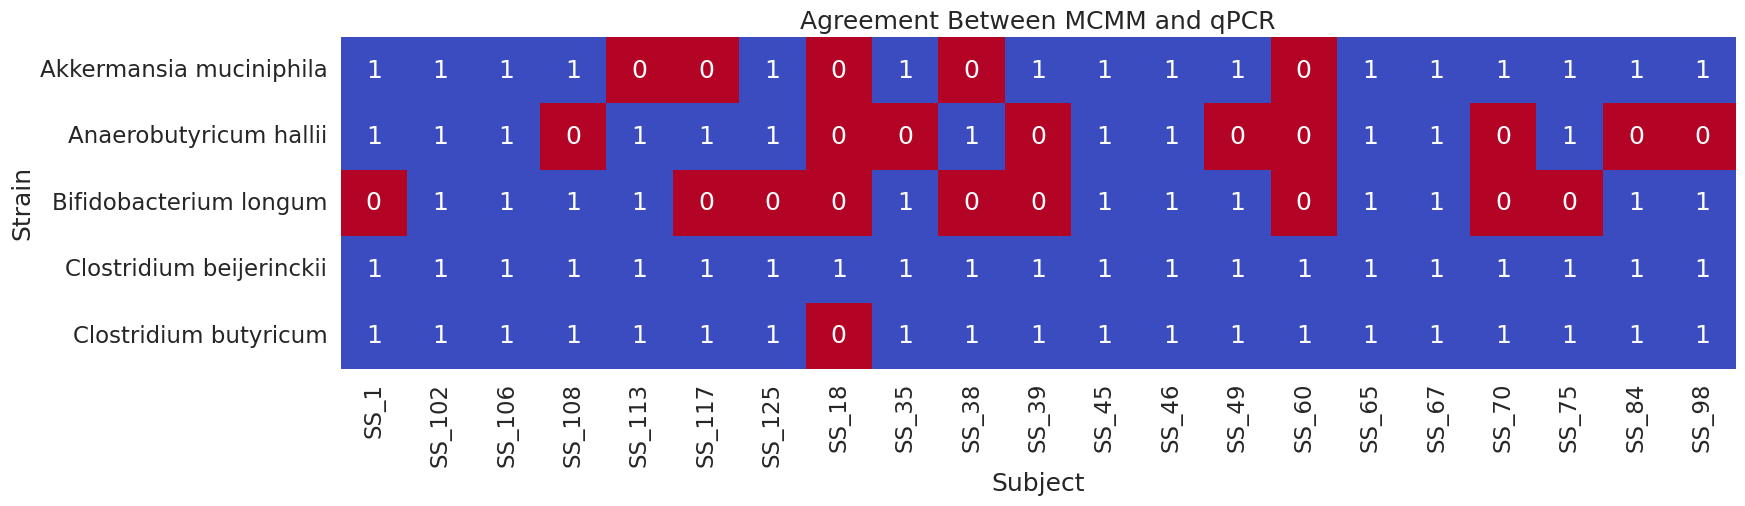

In [17]:
# Create qPCR Engraftment Pivot Table
df1 = pd.pivot_table(qPCR_wbf11[qPCR_wbf11['Week'] == '12'], 
                    index='Strain',
                    columns='Subject',
                    values='qPCR_engraftment').fillna(0.0)

# Create MCMM Engraftment Pivot Table
df2 = pd.pivot_table(rates_probiotic, 
                    index='compartments',
                    columns='subject_id',
                    values='MCMM_engraftment').fillna(0.0)

# Ensure both dataframes are numeric (convert from strings if necessary)
df1 = df1.astype(float)
df2 = df2.astype(float)

# Calculate agreement matrix
agreement_matrix = (df1 == df2).astype(int)

agreement_matrix.index = agreement_matrix.index.str.replace('_', ' ')
# Plot heatmap of agreement
plt.figure(figsize=(18, 6))
sns.set(font_scale=1.5) 
sns.heatmap(agreement_matrix, cmap='coolwarm_r', annot=True, cbar=False, square=True)
plt.title('Agreement Between MCMM and qPCR')
plt.savefig('../figures/agreement_heatmap_qPCR.svg', dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI

## Calculate Cohen's Kappa

In [18]:
ratings1 = df1.values.flatten()
ratings2 = df2.values.flatten()

# Compute Cohen's kappa
kappa = sklearn.metrics.cohen_kappa_score(ratings1, ratings2)

print(f"Cohen's kappa: {kappa:.4f}")

Cohen's kappa: 0.5120


## Calculate % Agreement

In [12]:
agree_ones = agreement_matrix.sum().sum()
growth_ones = df2.sum().sum()
total = agreement_matrix.size
print(str((agree_ones/total).round(4)*100)+'%')

77.14%


/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.


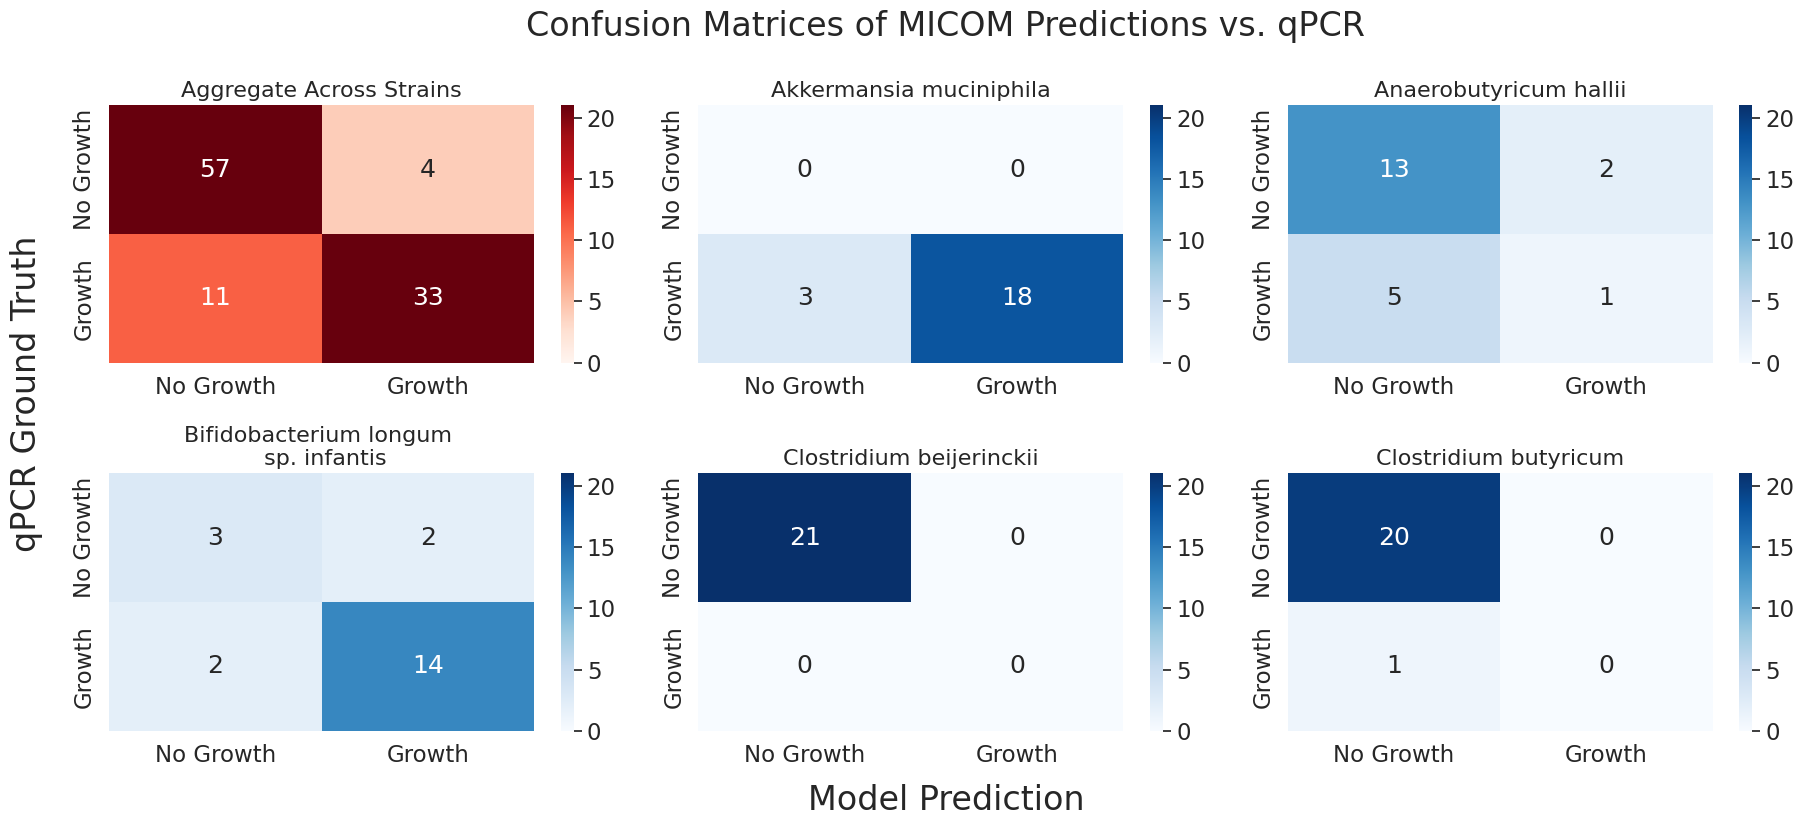

In [167]:
strains = df1.index

# Set up subplot grid: 2 rows, 3 columns (5 strains + 1 aggregate)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # Flatten for easy iteration

# Define consistent color limits
vmin, vmax = 0, 21

# Aggregate all results
all_y_true = df1.values.flatten()  # Flatten across all strains
all_y_pred = df2.values.flatten()

# Compute overall confusion matrix
cm_agg = confusion_matrix(all_y_true, all_y_pred)

# Ensure correct shape for formatting
if cm_agg.shape == (1, 1):
    cm_agg = np.array([[cm_agg[0, 0], 0], [0, 0]])

# Plot aggregated confusion matrix
sns.heatmap(cm_agg, annot=True, fmt="d", cmap="Reds",
            xticklabels=["No Growth", "Growth"],
            yticklabels=["No Growth", "Growth"],
            ax=axes[0], vmin=vmin, vmax=vmax)

# Loop through each strain
for i, strain in enumerate(strains):
    y_true = df1.loc[strain].values.flatten()
    y_pred = df2.loc[strain].values.flatten()

    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (1, 1):
        cm = np.array([[cm[0, 0], 0], [0, 0]])

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Growth", "Growth"],
                yticklabels=["No Growth", "Growth"],
                ax=axes[i+1], vmin=vmin, vmax=vmax)


axes[0].set_title("Aggregate Across Strains", fontsize=16)
axes[1].set_title('Akkermansia muciniphila', fontsize=16)
axes[2].set_title('Anaerobutyricum hallii', fontsize=16)
axes[3].set_title('Bifidobacterium longum \n sp. infantis', fontsize=16)
axes[4].set_title('Clostridium beijerinckii', fontsize=16)
axes[5].set_title('Clostridium butyricum', fontsize=16)

fig.suptitle("Confusion Matrices of MICOM Predictions vs. qPCR", fontsize=24)
fig.text(-0.02, 0.5, "qPCR Ground Truth", va='center', rotation='vertical', fontsize=24)
fig.text(0.5, -0.02, "Model Prediction", ha='center', fontsize=24)


plt.tight_layout()
plt.savefig('../figures/confusion_matricies.svg', dpi=300)  # Save as PNG with 300 DPI
plt.show()


In [103]:
y_true = df1.loc['Anaerobutyricum_hallii'].values.flatten()
y_pred = df2.loc['Anaerobutyricum_hallii'].values.flatten()

cm = confusion_matrix(y_true, y_pred)

if cm.shape == (1, 1):
    cm = np.array([[cm[0, 0], 0], [0, 0]])
scipy.stats.fisher_exact(cm_agg)

SignificanceResult(statistic=42.75, pvalue=1.29193289686301e-13)

In [99]:
cm

array([[21]])